# Build a biGRU neural network model

In this notebook, we are going to build a bidirectional Gated Recurrent Unit neural network model that will be capable of predicting with certain accuracy the future price movement of Stock Indexes, ETFs, Currencies or Commodities (whether the price will go up, down or stall). The accuracy of the model's predictions, especially in deep neural network strongly depends on the amount of training data. <b>I would like to emphasise that in this notebook the model will be trained on a very small dataset, thus the resulting performance of the model presented below deviates from its real capabilities</b>.

Data is collected from various sources, sometimes there is no historical data available, thus the gathering of data is conducted mainly in real-time. As soon as the dataset grows to a decent size, the model will be one more time trained, which should result in better prediction power.

The model is going to be trained on the 5 minute interval data (from MySQL/MariaDB database) that comprises the following input features:
- The SPDR S&P 500 order book (aggregated size of resting displayed orders at a price and side)
- Weighted average for bid's and ask's side orders
- Volume Imbalance
- Delta indicator
- Bid-Ask Spread
- Economic indicators such as Nonfarm Payrolls, Unemployment Rate, Building Permits, Core Retail Sales and others
- Commitment of Traders reports data
- CBOE Volatility Index
- Open, high, low, close prices, volume and wick percentage
- Bollinger Bands
- Stochastic Oscillator
- Average True Range
- Volume, price and Delta indicator moving averages
- The day of the week, week of the month, start session

This is the multi-label classification problem, in which the target variables are determined using following manner:

|                Condition                    |  up1  |  up2  | down1 | down2 |
| :------------------------------------------:|:-----:|:-----:|:-----:|:-----:|
| 8th bar p8_close >= p0_close + (n1 * ATR)   |   1   |   0   |   0   |   0   |
| 15th bar p15_close >= p0_close + (n2 * ATR) |   0   |   1   |   0   |   0   |
| 8th bar p8_close <= p0_close - (n1 * ATR)   |   0   |   0   |   1   |   0   |
| 15th bar p15_close <= p0_close - (n2 * ATR) |   0   |   0   |   0   |   1   |

In this notebook we used the following ATR factors:
- n1 = 1.5
- n2 = 3

You can generate different target variables by modifying <i>target_statement</i> in <i>create_database.py</i> file (use different condition or ATR factors).

### Building and training the model

Let's start with importing all indispensable libraries.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import device
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, hamming_loss, fbeta_score, multilabel_confusion_matrix
from sql_pytorch_dataloader import MySQLChunkLoader, MySQLBatchLoader, window_indices, TrainValTestSplit
import mysql.connector
from mysql.connector import errorcode
from config import mysql_user, mysql_password, mysql_hostname, mysql_database_name, mysql_table_name
from create_database import join_statement as db_x_query

We can print the db_x_query to see which columns (independent variables) are included in the SQL statement.

In [2]:
# print(db_x_query)

To choose different set of input variables, simply modify the db_x_query

In [3]:
# db_x_query = "SELECT sd.bid_0_size, sd.bid_1_size, sd.bid_2_size, sd.bid_3_size, sd.bid_4_size, sd.bid_5_size, sd.bid_6_size, sd.bid_1, sd.bid_2, sd.bid_3, sd.bid_4, sd.bid_5, sd.bid_6, sd.ask_0_size, sd.ask_1_size, sd.ask_2_size, sd.ask_3_size, sd.ask_4_size, sd.ask_5_size, sd.ask_6_size, sd.ask_1, sd.ask_2, sd.ask_3, sd.ask_4, sd.ask_5, sd.ask_6, sd.bids_ord_WA, sd.asks_ord_WA, sd.vol_imbalance, sd.delta, sd.micro_price, sd.spread, sd.session_start, sd.day_1, sd.day_2, sd.day_3, sd.day_4, sd.week_1, sd.week_2, sd.week_3, sd.week_4, sd.VIX, sd.1_open, sd.2_high, sd.3_low, sd.4_close, sd.5_volume, sd.wick_prct, sd.Asset_long_pos, sd.Asset_long_pos_change, sd.Asset_long_open_int, sd.Asset_short_pos, sd.Asset_short_pos_change, sd.Asset_short_open_int, sd.Leveraged_long_pos, sd.Leveraged_long_pos_change, sd.Leveraged_long_open_int, sd.Leveraged_short_pos, sd.Leveraged_short_pos_change, sd.Leveraged_short_open_int, sd.Crude_Oil_Inventories_Actual, sd.Crude_Oil_Inventories_Prev_actual_diff, sd.Crude_Oil_Inventories_Forc_actual_diff, sd.ISM_Non_Manufacturing_PMI_Actual, sd.ISM_Non_Manufacturing_PMI_Prev_actual_diff, sd.ISM_Non_Manufacturing_PMI_Forc_actual_diff, sd.ISM_Non_Manufacturing_Employment_Actual, sd.ISM_Non_Manufacturing_Employment_Prev_actual_diff, sd.ISM_Non_Manufacturing_Employment_Forc_actual_diff, sd.Services_PMI_Actual, sd.Services_PMI_Prev_actual_diff, sd.Services_PMI_Forc_actual_diff, sd.ADP_Nonfarm_Employment_Change_Actual, sd.ADP_Nonfarm_Employment_Change_Prev_actual_diff, sd.ADP_Nonfarm_Employment_Change_Forc_actual_diff, sd.Core_CPI_Actual, sd.Core_CPI_Prev_actual_diff, sd.Core_CPI_Forc_actual_diff, sd.Fed_Interest_Rate_Decision_Actual, sd.Fed_Interest_Rate_Decision_Prev_actual_diff, sd.Fed_Interest_Rate_Decision_Forc_actual_diff, sd.Building_Permits_Actual, sd.Building_Permits_Prev_actual_diff, sd.Building_Permits_Forc_actual_diff, sd.Core_Retail_Sales_Actual, sd.Core_Retail_Sales_Prev_actual_diff, sd.Core_Retail_Sales_Forc_actual_diff, sd.Retail_Sales_Actual, sd.Retail_Sales_Prev_actual_diff, sd.Retail_Sales_Forc_actual_diff, sd.JOLTs_Job_Openings_Actual, sd.JOLTs_Job_Openings_Prev_actual_diff, sd.JOLTs_Job_Openings_Forc_actual_diff, sd.Nonfarm_Payrolls_Actual, sd.Nonfarm_Payrolls_Prev_actual_diff, sd.Nonfarm_Payrolls_Forc_actual_diff, sd.Unemployment_Rate_Actual, sd.Unemployment_Rate_Prev_actual_diff, sd.Unemployment_Rate_Forc_actual_diff, bb.upper_BB_dist, bb.lower_BB_dist, vol.vol_MA6, vol.vol_MA20, p.price_MA20, d.delta_MA12, so.stoch, ATR.ATR, pc.price_change FROM stock_data_joined sd JOIN bollinger_bands bb ON sd.Timestamp = bb.Timestamp JOIN vol_MA vol ON sd.Timestamp = vol.Timestamp JOIN price_MA p ON sd.Timestamp = p.Timestamp JOIN delta_MA d ON sd.Timestamp = d.Timestamp JOIN stochastic_oscillator so ON sd.Timestamp = so.Timestamp JOIN ATR ON sd.Timestamp = ATR.Timestamp JOIN price_change pc ON sd.Timestamp = pc.Timestamp;"

Next step is to connect to MySQL/MariadDB server and create a cursor object that will be used to execute SQL statements.

In [4]:
# Connect to MySQL server
try:
    cnx = mysql.connector.connect(host=mysql_hostname, user=mysql_user, password=mysql_password)
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("User name or password incorrect")
    else:
        print(err)
    # Close connection
    cnx.close()
    print('Connection closed')

# Instantiate cursor object
db_cursor = cnx.cursor()

# Use given database
db_cursor.execute("USE {};".format(mysql_database_name))

Now we can specify target variables, chunk_size and window size.

In [5]:
y_fields = "up1, up2, down1, down2"
chunk_size = 50
window = 5

Below we will instantiate MySQLChunkLoader object that is responsible for generating indices of database rows that form a chunk of MySQL/MariaDB database parameterized by chunk_size (chunking is used to diminish memory usage while parsing).
Chunk loader also calculates data chunk's normalization parameters - minimum and maximum, pass them to MySQLBatchLoader and save locally. Normalization parameters subsequently can be used by MySQLBatchLoader to normalize training batches (according to MIN and MAX of a chunk to which given batch belongs to) as well as to normalize validation and test sets during evaluation or real-time inference.

In [6]:
# Instantiate MySQLChunkLoader object
chunk_loader = MySQLChunkLoader(cursor=db_cursor, table=mysql_table_name, db_x_query=db_x_query, 
                                chunk_size=chunk_size, window=window)

TrainValTestSplit performs Train/Validation/Test splitting of a set of data chunks, which means that val_size and test_size parameters refere to number of chunks (not to total number of data points!)

For instance, If we have dataset that consits of 16 chunks and we use val_size=0.1 and test_size=0.1 then spliting 
will be performed in following manner: 
- train_set -> will contain 0.8 * 16 chunks = 12 chunks
- val_size -> (0.1 * 16) + 1 = 2 chunks
- test_size -> (0.1 * 16) + 1 = 2 chunks

In [5]:
# Split dataset into training, validation and test sets
split = TrainValTestSplit(chunk_loader, val_size=0.1, test_size=0.1)
train_set, val_set, test_set = split.get_sets()

MySQLBatchLoader consecutively generates indices of database rows in a sliding window manner to be read from
chunk of a MySQL/MariaDB database.

Example of generating sliding windows within chunks of data:

| DB table | Table chunks | Sliding windows |
|:--:|:--:|:--:|
|1. |  1. | 1., 2. |
|2. | 2. | -------- |
|3. | 3. | 2., 3. |
|4. | --------| -------- |
|5. | 3. |3., 4. |
|   | 4. | -------- |
|   | 5. | 4., 5. |

We have to check out how batches that we created look like before we pass them into the model.

In [6]:
# It is possible to loop through all batches only once. Thus the split.get_sets() method
# have to be called always befor looping through (training, validation or test) set in order to generate
# indices and norm_params.
for indices, norm_params in train_set:

    train_loader = DataLoader(MySQLBatchLoader(indices=indices, norm_params=norm_params, cursor=db_cursor,
                                   table=mysql_table_name, db_x_query=db_x_query, y_fields=y_fields,
                                   window=window), batch_size=2)
    for batch in train_loader:
        x, y = batch
        # x size: batch_size, seq_len, n_features
        print(x)
        print("--------------")
        # y size: batch_size, 1, n_classes
        print(y)
        break
        
    print("\nNEXT BATCH")
    break

tensor([[[0.0000, 0.1818, 0.1818,  ..., 0.7917, 1.0000, 0.6509],
         [0.1818, 0.2727, 0.1818,  ..., 0.8959, 0.7085, 0.7925],
         [0.0000, 0.1818, 0.1818,  ..., 0.5000, 0.5757, 0.5660],
         [0.1818, 0.1818, 0.1818,  ..., 0.9375, 0.5798, 0.9434],
         [0.8636, 0.0455, 0.9545,  ..., 1.0000, 0.3568, 0.7925]],

        [[0.1818, 0.2727, 0.1818,  ..., 0.8959, 0.7085, 0.7925],
         [0.0000, 0.1818, 0.1818,  ..., 0.5000, 0.5757, 0.5660],
         [0.1818, 0.1818, 0.1818,  ..., 0.9375, 0.5798, 0.9434],
         [0.8636, 0.0455, 0.9545,  ..., 1.0000, 0.3568, 0.7925],
         [0.8636, 0.0455, 0.9545,  ..., 0.5400, 0.3518, 0.5283]]])
--------------
tensor([[[0., 0., 1., 1.]],

        [[0., 0., 0., 1.]]])

NEXT BATCH


Below we will check how the train/val/test splitting was performed.

In [7]:
print("Number of chunks in dataset: ", split.dataset_len + 1)
print("Number of chunks in training set: ", split.train_end_idx)
print("Number of chunks in validation set: ", split.val_end_idx - split.train_end_idx)
print("Number of chunks in test set: ", split.test_end_idx - split.val_end_idx)

Number of chunks in dataset:  12
Number of chunks in training set:  8
Number of chunks in validation set:  2
Number of chunks in test set:  2


Next step is to build the biGRU model.

In [8]:
class BiGRU(nn.Module):
    """BiDirectional GRU neural network model.
        
    Parameters
    ----------
    hidden_size: int
        Number of features in the hidden state.
    n_features: int
        Number of the input features.
    output_size: int
        Number of classes.
    n_layers: int, optional (default=1)
        Number of stacked recurrent layers.
    clip: int, optional (default=50)
        Max norm of the gradients.
    dropout: float, optional (default=0.2)
        Probability of an element of the tensor to be zeroed.
    spatial_dropout: boolean, optional (default=True)
        Whether to use the spatial dropout.
    bidirectional: boolean, optional (default=True)
        Whether to use the bidirectional GRU.

    """
    
    def __init__(self, hidden_size, n_features, output_size, n_layers=1, clip=50, dropout=0.2,
                 spatial_dropout=True, bidirectional=True):
        
        # Inherit everything from the nn.Module
        super(BiGRU, self).__init__()
        
        # Initialize attributes
        self.hidden_size = hidden_size
        self.n_features = n_features
        self.output_size = output_size
        self.n_layers = n_layers
        self.clip = clip
        self.dropout_p = dropout
        self.spatial_dropout = spatial_dropout
        self.bidirectional = bidirectional
        self.n_directions = 2 if self.bidirectional else 1
        
        # Initialize layers
        self.dropout = nn.Dropout(self.dropout_p)
        if self.spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(self.dropout_p)
            
        self.gru = nn.GRU(self.n_features, self.hidden_size, num_layers=self.n_layers, 
                          dropout=(0 if n_layers == 1 else self.dropout_p), batch_first=True,
                          bidirectional=self.bidirectional)
        
        # Linear layer input size is equal to hidden_size * 3, becuase
        # we will concatenate max_pooling ,avg_pooling and last hidden state
        self.linear = nn.Linear(self.hidden_size * 3, self.output_size)

        
    def forward(self, input_seq, hidden=None):
        """Forward propagates through the neural network model.
        
        Parameters
        ----------
        input_seq: torch.Tensor
            Batch of input sequences.
        hidden: torch.FloatTensor, optional (default=None)
            Tensor containing initial hidden state.
            
        Returns
        -------
        torch.Tensor
            Logits - vector of raw predictions in range (-inf, inf). Probability of 0.5 corresponds
            to a logit of 0. Positive logits correspond to probabilities greater than 0.5, while negative
            to probabilities less than 0.5.
        
        """
        # Extract batch_size
        self.batch_size = input_seq.size(0)
        
        # Sequence length
        self.input_length = input_seq.size(1)
        
        if self.spatial_dropout:
            # Convert to (batch_size, n_features, seq_length)
            input_seq = input_seq.permute(0, 2, 1)
            input_seq = self.spatial_dropout1d(input_seq)
            # Convert back to (batch_size, seq_length, n_features)
            input_seq = input_seq.permute(0, 2, 1)
        else:
            input_seq = self.dropout(input_seq)
                
        # GRU input/output shapes, if batch_first=True
        # Input: (batch_size, seq_len, n_features)
        # Output: (batch_size, seq_len, hidden_size*num_directions)
        # Number of directions = 2 when used bidirectional, otherwise 1
        # shape of hidden: (n_layers x num_directions, batch_size, hidden_size)
        # Hidden state defaults to zero if not provided
        gru_out, hidden = self.gru(input_seq, hidden)
        # gru_out: tensor containing the output features h_t from the last layer of the GRU
        # gru_out comprises all the hidden states in the last layer ("last" depth-wise, not time-wise)
        # For biGRu gru_out is the concatenation of a forward GRU representation and a backward GRU representation
        # hidden (h_n) comprises the hidden states after the last timestep
        
        # Extract and sum last hidden state
        # Input hidden shape: (n_layers x num_directions, batch_size, hidden_size)
        # Separate hidden state layers
        hidden = hidden.view(self.n_layers, self.n_directions, self.batch_size, self.hidden_size)
        last_hidden = hidden[-1]
        # last hidden shape (num_directions, batch_size, hidden_size)
        # Sum the last hidden state of forward and backward layer
        last_hidden = torch.sum(last_hidden, dim=0)
        # Summed last hidden shape (batch_size, hidden_size)
              
        # Sum the gru_out along the num_directions
        if self.bidirectional:
            gru_out = gru_out[:,:,:self.hidden_size] + gru_out[:,:,self.hidden_size:]
        
        # Select the maximum value over each dimension of the hidden representation (max pooling)
        # Permute the input tensor to dimensions: (batch_size, hidden, seq_len)
        # Output dimensions: (batch_size, hidden_size)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(0,2,1), (1,)).view(self.batch_size,-1)
        
        # Consider the average of the representations (mean pooling)
        # Sum along the batch axis and divide by the corresponding length (FloatTensor)
        # Output shape: (batch_size, hidden_size)
        avg_pool = torch.sum(gru_out, dim=1) / torch.FloatTensor([self.input_length])

        # Concatenate max_pooling, avg_pooling and last hidden state tensors
        concat_out = torch.cat([last_hidden, max_pool, avg_pool], dim=1)

        # concat_out = self.dropout(concat_out)
        # output_size: batch_size, output_size
        out = self.linear(concat_out)
        return out
    
    
    def add_loss_fn(self, loss_fn):
        """Add loss function to the model.
        
        """
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):
        """Add optimizer to the model.
        
        """
        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):
        """Specify the device.
        
        """
        self.device = device
    
    
    def train_model(self, train_iterator):
        """Performs single training epoch.
        
        Parameters
        ----------
        train_iterator: torch.utils.data.dataloader.DataLoader
            Pytorch dataloader of MySQLBatchLoader dataset.
            
        Returns
        -------
        accuracies: float
            Mean accuracy.
        hamm_losses: float
            Mean Hamming loss.
        losses: float
            Mean loss.
        fbetas_list: list
            Mean fbeta score within each class.
            
        """
        self.train()
        
        losses = []
        accuracies = []
        hamm_losses = []
        fbetas_list = []
            
        for input_seq, target in train_iterator:
            # input_seq size: batch_size, seq_len, n_features
            # target size: batch_size, 1, n_classes           
            # Reshape target to size: batch_size, n_classes
            target = target.squeeze(1)

            input_seq.to(self.device)
            target.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq)

            loss = self.loss_fn(pred, target)
            
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            
            # Clip gradients: gradients are modified in place
            _ = nn.utils.clip_grad_norm_(self.parameters(), self.clip)
            
            self.optimizer.step()
            
            # Map logits to probabilities and extract labels using threshold
            pred = torch.sigmoid(pred) > 0.5
                        
            ac_score = accuracy_score(target, pred)           
            accuracies.append(ac_score)

            hamm_loss = hamming_loss(target, pred)
            hamm_losses.append(hamm_loss)
            
            fbeta = fbeta_score(target, pred, beta=0.5, average=None)
            fbetas_list.append(fbeta)
                              
        return np.mean(accuracies), np.mean(hamm_losses), np.mean(losses), np.mean(fbetas_list, axis=0)
    
    
    def evaluate_model(self, eval_iterator):
        """Perform the one evaluation epoch.
        
        Parameters
        ----------
        eval_iterator: torch.utils.data.dataloader.DataLoader
            Pytorch dataloader of MySQLBatchLoader dataset.
            
        Returns
        -------
        accuracies: float
            Mean accuracy.
        hamm_losses: float
            Mean Hamming loss.
        fbetas_list: list
            Mean fbeta score within each class.
        pred_total: torch.LongTensor()
            Tensor containing chunk's generated predictions 
        target_total: torch.LongTensor()
            Tensor containing chunk's target variables.
            
        """
        self.eval()

        losses = []
        accuracies = []
        hamm_losses = []
        fbetas_list = []
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for input_seq, target in eval_iterator:
                target = target.squeeze(1)

                input_seq.to(self.device)
                target.to(self.device)

                pred = self.forward(input_seq)

                # loss = self.loss_fn(pred, target)
                
                # losses.append(loss.data.cpu().numpy())
                
                # Map logits to probabilities and extract labels using threshold
                pred = torch.sigmoid(pred) > 0.5

                ac_score = accuracy_score(target, pred)           
                accuracies.append(ac_score)

                hamm_loss = hamming_loss(target, pred)
                hamm_losses.append(hamm_loss)

                fbeta = fbeta_score(target, pred, beta=0.5, average=None)
                fbetas_list.append(fbeta)
                
                pred_total = torch.cat([pred_total, pred.type(torch.LongTensor)], dim=0)
                target_total = torch.cat([target_total, target.type(torch.LongTensor)], dim=0)
        
        return  np.mean(accuracies), np.mean(hamm_losses), np.mean(fbetas_list, axis=0), pred_total, target_total

Now we will instantiate the model, add loss function, optimizer, and device to it and begin the training.

In [9]:
# Initialize parameters
batch_size = 2
hidden_size = 8
n_features = len(chunk_loader.x_fields)
output_size = len(y_fields.split(", "))
n_layers = 1
clip = 50
dropout = 0.2
learning_rate = 0.001
epochs = 20
spatial_dropout = False

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = BiGRU(hidden_size, n_features, output_size, n_layers, clip, dropout,
              spatial_dropout, bidirectional=True)

# Move the model to GPU if possible
if CUDA:
    model.cuda()
    
model.add_loss_fn(nn.MultiLabelSoftMarginLoss())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

hamming_avg_loss_list = []
eval_hamming_avg_loss_list = []

for epoch in range(epochs):
    
    print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))
    
    train_losses_list, train_accuracy_list, fbetas_list, hamming_loss_list = [], [], [], []
    eval_accuracy_list, eval_fbetas_list, conf_matrix_list, eval_hamming_loss_list = [], [], [], []
    
    eval_pred_total = torch.LongTensor()
    eval_target_total = torch.LongTensor()
    
    split = TrainValTestSplit(chunk_loader, val_size=0.1, test_size=0.1)
    train_set, val_set, _ = split.get_sets()
     
    for indices, norm_params in train_set:
        
        train_iterator = DataLoader(MySQLBatchLoader(indices=indices, norm_params=norm_params, cursor=db_cursor,
                                   table=mysql_table_name, db_x_query=db_x_query, y_fields=y_fields,
                                   window=window), batch_size=batch_size)

        accuracy, hamm_loss, loss, fbeta = model.train_model(train_iterator)
        
        train_accuracy_list.append(accuracy)
        hamming_loss_list.append(hamm_loss)
        train_losses_list.append(loss)
        fbetas_list.append(fbeta)

    train_accuracy = np.mean(train_accuracy_list)
    hamming_loss_total = np.mean(hamming_loss_list)
    loss_total = np.mean(train_losses_list)
    fbeta_total = np.mean(fbetas_list, axis=0)

    print('\nEpoch [{}/{}]: Train accuracy: {:.3f}, Hamming loss: {:.3f}, Loss: {:.3f}, fbeta: {}'\
          .format(epoch+1, epochs, train_accuracy, hamming_loss_total, loss_total, fbeta_total))

    for indices, norm_params in val_set:
        
        val_iterator = DataLoader(MySQLBatchLoader(indices=indices, norm_params=norm_params, cursor=db_cursor,
                           table=mysql_table_name, db_x_query=db_x_query, y_fields=y_fields,
                           window=window), batch_size=batch_size)
        
        accuracy, hamm_loss, fbeta, pred, target = model.evaluate_model(val_iterator)
        
        eval_accuracy_list.append(accuracy)
        eval_hamming_loss_list.append(hamm_loss)
        eval_fbetas_list.append(fbeta)
        
        eval_pred_total = torch.cat([eval_pred_total, pred], dim=0)
        eval_target_total = torch.cat([eval_target_total, target], dim=0)

    eval_conf_matrix = multilabel_confusion_matrix(eval_target_total, eval_pred_total)
        
    eval_accuracy = np.mean(eval_accuracy_list)
    eval_hamming_loss_total = np.mean(eval_hamming_loss_list)
    eval_fbeta_total = np.mean(eval_fbetas_list, axis=0)
    
    print('\nEpoch [{}/{}]: Evaluation accuracy: {:.3f}, Eval Hamming loss: {:.3f}, Eval fbeta: {}'\
      .format(epoch+1, epochs, eval_accuracy, eval_hamming_loss_total, eval_fbeta_total))
    
    print("Evaluation Confusion matrix: \n", eval_conf_matrix)
    
    hamming_avg_loss_list.append(np.mean(hamming_loss_list))
    eval_hamming_avg_loss_list.append(np.mean(eval_hamming_loss_list))
    


Start epoch [1/20]


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Epoch [1/20]: Train accuracy: 0.156, Hamming loss: 0.350, Loss: 0.648, fbeta: [0.06944444 0.         0.08125    0.01388889]

Epoch [1/20]: Evaluation accuracy: 0.800, Eval Hamming loss: 0.050, Eval fbeta: [0. 0. 0. 0.]
Evaluation Confusion matrix: 
 [[[32  0]
  [ 8  0]]

 [[40  0]
  [ 0  0]]

 [[40  0]
  [ 0  0]]

 [[40  0]
  [ 0  0]]]

Start epoch [2/20]

Epoch [2/20]: Train accuracy: 0.325, Hamming loss: 0.250, Loss: 0.580, fbeta: [0. 0. 0. 0.]

Epoch [2/20]: Evaluation accuracy: 0.800, Eval Hamming loss: 0.050, Eval fbeta: [0. 0. 0. 0.]
Evaluation Confusion matrix: 
 [[[32  0]
  [ 8  0]]

 [[40  0]
  [ 0  0]]

 [[40  0]
  [ 0  0]]

 [[40  0]
  [ 0  0]]]

Start epoch [3/20]

Epoch [3/20]: Train accuracy: 0.331, Hamming loss: 0.248, Loss: 0.565, fbeta: [0.0125 0.     0.     0.    ]

Epoch [3/20]: Evaluation accuracy: 0.800, Eval Hamming loss: 0.050, Eval fbeta: [0. 0. 0. 0.]
Evaluation Confusion matrix: 
 [[[32  0]
  [ 8  0]]

 [[40  0]
  [ 0  0]]

 [[40  0]
  [ 0  0]]

 [[40  0]
  [

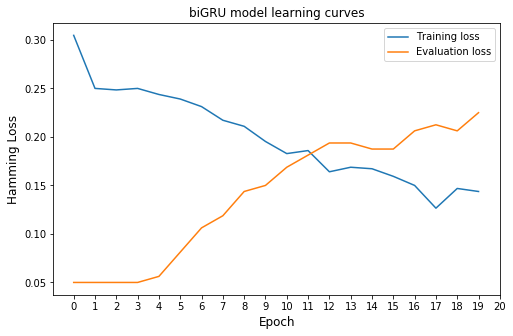

In [44]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(hamming_avg_loss_list, label='Training loss')
plt.plot(eval_hamming_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Hamming Loss', size=12)
plt.title('biGRU model learning curves')
plt.xticks(ticks=range(epochs+1))
plt.legend()
plt.show()

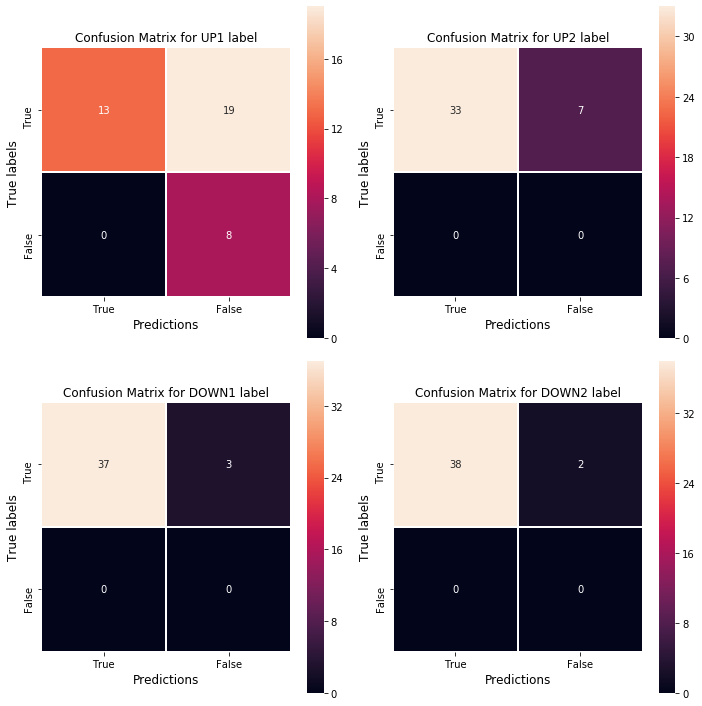

In [38]:
# Create the figure and axes instances
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
label_idx = 0
labels = y_fields.split(", ")

# Iterate through rows and columns of a plot
for row in range(2):
    for col in range(2):
        if label_idx <= output_size - 1:
            # Confusion matrix
            ax = sns.heatmap(eval_conf_matrix[label_idx], fmt='d', annot=True, linewidths=1,
                             square=True, ax=axes[row, col])
            ax.set_xlabel('Predictions', size=12)
            ax.set_ylabel('True labels', size=12) 
            ax.set_title('Confusion Matrix for {} label'.format(labels[label_idx].upper()), size=12); 
            ax.xaxis.set_ticklabels(['True', 'False'])
            ax.yaxis.set_ticklabels(['True', 'False'])
            ax.set_ylim(2,0)
        else:
            # Delete unnecessary axes
            fig.delaxes(axes[row, col])
        label_idx += 1   
        
# Automatically adjusts subplot params to fit in figure       
plt.tight_layout()

### The generalization error

In [32]:
split = TrainValTestSplit(chunk_loader, val_size=0.1, test_size=0.1)
_, _, test_set = split.get_sets()

In [33]:
test_accuracy_list, test_fbetas_list, test_conf_matrix_list, test_hamming_loss_list = [], [], [], []

test_pred_total = torch.LongTensor()
test_target_total = torch.LongTensor()

In [34]:
for indices, norm_params in test_set:
    
    test_iterator = DataLoader(MySQLBatchLoader(indices=indices, norm_params=norm_params, cursor=db_cursor,
                       table=mysql_table_name, db_x_query=db_x_query, y_fields=y_fields,
                       window=window), batch_size=batch_size)

    accuracy, hamm_loss, fbeta, pred, target = model.evaluate_model(test_iterator)

    test_accuracy_list.append(accuracy)
    test_hamming_loss_list.append(hamm_loss)
    test_fbetas_list.append(fbeta)

    test_pred_total = torch.cat([test_pred_total, pred], dim=0)
    test_target_total = torch.cat([test_target_total, target], dim=0)
    
test_conf_matrix = multilabel_confusion_matrix(test_target_total, test_pred_total)

In [35]:
print('Test accuracy: {:.3f}. Test error: {:.3f}, Test fbeta: {}'\
      .format(np.mean(test_accuracy_list), np.mean(test_hamming_loss_list), np.mean(test_fbetas_list, axis=0)))

Test accuracy: 0.333. Test error: 0.208, Test fbeta: [0. 0. 0. 0.]


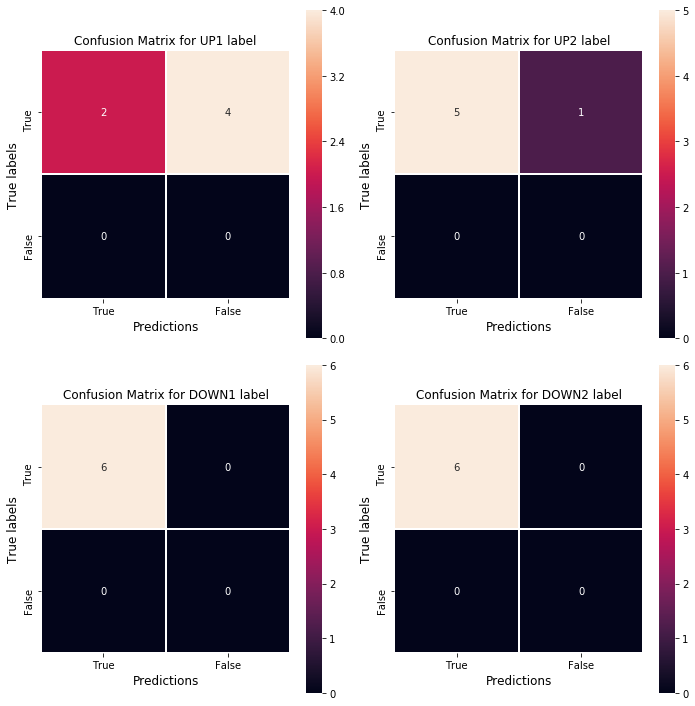

In [39]:
# Create the figure and axes instances
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False)
label_idx = 0
labels = y_fields.split(", ")

# Iterate through rows and columns of a plot
for row in range(2):
    for col in range(2):
        if label_idx <= output_size - 1:
            # Confusion matrix
            ax = sns.heatmap(test_conf_matrix[label_idx], fmt='d', annot=True, linewidths=1,
                             square=True, ax=axes[row, col])
            ax.set_xlabel('Predictions', size=12)
            ax.set_ylabel('True labels', size=12) 
            ax.set_title('Confusion Matrix for {} label'.format(labels[label_idx].upper()), size=12); 
            ax.xaxis.set_ticklabels(['True', 'False'])
            ax.yaxis.set_ticklabels(['True', 'False'])
            ax.set_ylim(2,0)
        else:
            # Delete unnecessary axes
            fig.delaxes(axes[row, col])
        label_idx += 1   
        
# Automatically adjusts subplot params to fit in figure       
plt.tight_layout()

### Save the model's learned parameters for Inference

In [37]:
path = 'model_params.pt'
torch.save(model.state_dict(), path)